# Twiss

This is an example of plotting lines and twiss results.
First, create a simple line and a tracker:

In [1]:
%load_ext autoreload
%autoreload 2

import xtrack as xt
import xpart as xp
import xplt
import numpy as np

xplt.apply_style()

In [2]:
## Generate a simple 6-fold symmetric FODO lattice

n = 6  # number of sections
elements = {
    "QF": xt.Multipole(length=0.3, knl=[0, +0.63]),
    "QD": xt.Multipole(length=0.3, knl=[0, -0.48]),
    "MU": xt.Multipole(length=0.5, knl=[np.pi / n], hxl=[np.pi / n]),
}
parts = {
    "a": [
        xt.Node(0.7, "QF"),
        xt.Node(1.4, "MU"),
        xt.Node(2.1, "QD"),
        xt.Node(2.8, "MU"),
    ],
    "b": [
        xt.Node(2.2, "MU"),
        xt.Node(2.9, "QD"),
        xt.Node(3.6, "MU"),
        xt.Node(4.3, "QF"),
    ],
}
nodes = [xt.Node(5.0 * i, "a" if i % 2 else "b", name=f"S{i+1}") for i in range(n)]

# sextupoles
for i in range(n):
    sx = xt.Multipole(length=0.2, knl=[0, 0, 0.5 * np.sin(2 * np.pi * (i / n))])
    nodes.append(xt.Node(0.2, sx, from_=f"S{i+1}", name=f"S{i+1}SX"))

line = xt.Line.from_sequence(
    nodes, length=5.0 * n, sequences=parts, elements=elements, auto_reorder=True
)
line.particle_ref = xp.Particles()
line.build_tracker();

Found suitable prebuilt kernel `default_only_xtrack`.


Then determine it's twiss parameters. We use the `at_s` parameter to get the result as function of s rather than at each element only.

In [3]:
tw = line.twiss(
    method="4d", at_s=np.linspace(0, line.get_length(), 500, endpoint=False)
)

Found suitable prebuilt kernel `only_xtrack_frozen_energy`.


## Default twiss plot

Create a default {class}`TwissPlot <xplt.twiss.TwissPlot>`:

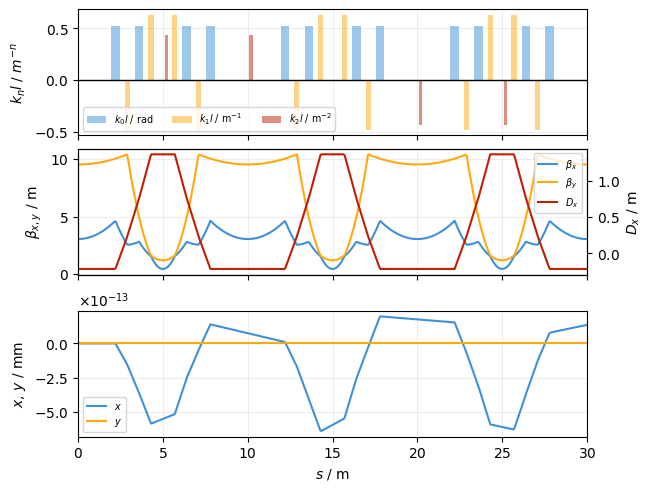

In [4]:
plot = xplt.TwissPlot(tw, line=line)

## Customisation

Use the parameter `kind` to specify what is plotted. See {class}`TwissPlot <xplt.twiss.TwissPlot>` for details.

In [5]:
print(", ".join(sorted(tw.keys(), key=lambda a: a.lower())))

alfx, alfy, beta0, betx, betx1, betx2, bety, bety1, bety2, betz0, c_minus, c_r1_avg, c_r2_avg, circumference, delta, dmux, dmuy, dpx, dpy, dqx, dqy, dx, dx_zeta, dy, dy_zeta, dzeta, gamma0, gamx, gamy, line_config, method, momentum_compaction_factor, mux, muy, muzeta, name, nux, nuy, nuzeta, only_markers, orientation, p0c, particle_on_co, ptau, px, py, qs, qx, qy, R_matrix, radiation_method, reference_frame, s, slip_factor, steps_r_matrix, T_rev0, values_at, W_matrix, x, y, zeta


```{tip}
Use prefix notation as shorthand to plot both x- and y-properties, e.g. `bet` for `betx+bety`
```

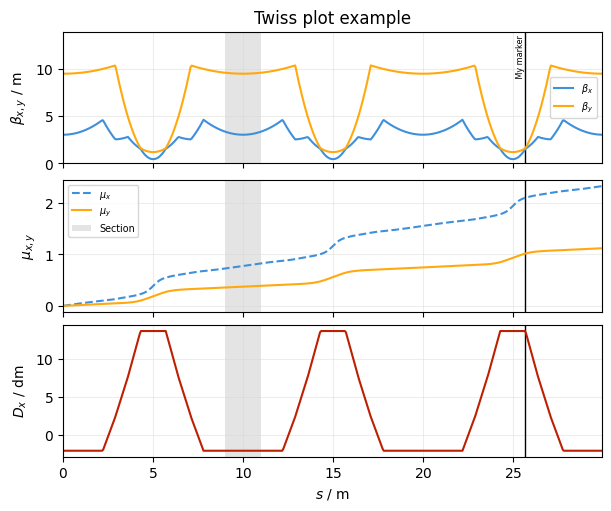

In [6]:
plot = xplt.TwissPlot(
    tw, figsize=(6, 5), kind="bet,mux+muy,dx", display_units=dict(d="dm")
)

# add some annotations
plot.axline(
    "s", line.get_s_position("S6QF"), annotation="My marker", annotation_loc="upper"
)
plot.axspan("s", 9, 11, label="Section")

# adjust some axes
plot.axis(0).set(title="Twiss plot example", ylim=(0, 14))

# adjust line layout
plot.artist("mux").set(ls="--")
plot.artist(subplot=2).set(c="pet2")

# legend is shown by default for subplots with more than 1 trace
plot.legend(1, loc="upper left")  # call it manually to reflect updated line layout
# plot.legend() # uncomment this to show legends on all subplots

-----------------
```{seealso}
- {class}`xplt.twiss`
```